This notebook aims to train and test 11 machine learning models using 10-fold cross-validation in order to investigate their ability to predict biological age from the top 50 CpG sites most significantly associated with age.

First, I will read in significant_betas.csv 

In [161]:
#import packages
from pathlib import Path
from mepylome import MethylData
import pandas as pd
import csv
import numpy as np
import pandas as pd

In [162]:
significant = pd.read_csv("significant_betas.csv")
significant.head(10)

,ID,Age,cg16867657,cg22454769,cg07082267,cg10917602,cg23744638,cg26153045,cg02085953,cg07927379,...,cg00292135,cg11693709,cg23737927,cg16624521,cg25994988,cg06761850,cg02315732,cg20732076,cg04608933,cg11436767
0,1,89.901370,0.702134,0.617247,0.309282,0.480625,0.556098,0.321821,0.314697,0.073288,...,0.114535,0.256534,0.586134,0.656403,0.411849,0.292660,0.398222,0.105039,0.653653,0.373123
1,2,94.000000,0.729290,0.731379,0.213783,0.449248,0.494431,0.324626,0.296414,0.018520,...,0.174267,0.231969,0.604058,0.568733,0.336492,0.339834,0.321057,0.041996,0.619470,0.282783
2,3,97.879450,0.688162,0.681539,0.342350,0.498799,0.566515,0.213102,0.275044,0.040328,...,0.134725,0.198174,0.612303,0.565486,0.348359,0.183476,0.414816,0.065445,0.648604,0.316858
3,4,66.530134,0.646309,0.486484,0.380866,0.583188,0.569642,0.375602,0.354024,0.042392,...,0.114310,0.417675,0.759947,0.681296,0.474299,0.296988,0.560873,0.190937,0.675305,0.406668
4,4,73.568486,0.799299,0.495504,0.357534,0.543829,0.527590,0.311308,0.308736,0.043762,...,0.107074,0.411936,0.833769,0.659152,0.384782,0.281054,0.561824,0.155627,0.655442,0.400266
5,4,82.403833,0.737156,0.547054,0.414491,0.577654,0.553128,0.342647,0.267324,0.160710,...,0.150684,0.392358,0.639692,0.683428,0.451075,0.311980,0.428577,0.153598,0.706284,0.374923
6,4,84.528405,0.837627,0.559392,0.355323,0.525814,0.521606,0.253690,0.271183,0.079572,...,0.089873,0.393527,0.699139,0.644453,0.331450,0.325187,0.373445,0.112596,0.678522,0.353805
7,5,66.530134,0.702288,0.526904,0.361381,0.543922,0.672069,0.348870,0.322995,0.105713,...,0.141782,0.382297,0.741858,0.559220,0.405146,0.290188,0.452989,0.120012,0.625062,0.417433
8,5,73.852509,0.820860,0.577691,0.373576,0.498148,0.614670,0.316506,0.343476,0.077343,...,0.178324,0.347342,0.727501,0.505839,0.344634,0.308590,0.524471,0.104955,0.599907,0.342823
9,5,82.403833,0.838836,0.572076,0.304438,0.486565,0.655282,0.244592,0.348290,0.133586,...,0.159521,0.314774,0.627057,0.513647,0.366603,0.238929,0.452037,0.105946,0.573729,0.392948


significant contains:
- ID of the 385 Swedish twins for each of the 1072 samples
- Age at each sample
- Beta values at each of the top 50 CpG sites significantly associated with age

Next, I will use 10-fold cross-validation to split the observations into training and test sets. The observations include the sites most significantly associated with age. I will fit the model with the training set and then use the test set to test the predictive performance of the model by computing the root mean squared error (RMSE), mean absolute error (MAE), Pearson correlation coefficient (r) and coefficient of determination ($R^2$). 

In [163]:
from sklearn.model_selection import KFold
import joblib

X, y = significant.drop(columns=['ID', 'Age']), significant['Age']

# split the observations into training and test sets that are used across the models
kf = KFold(n_splits=10, shuffle=True, random_state=42)
splits = list(kf.split(X))

I will define two functions, evaluate_model_normalise and evaluate_model, which both train and test the model. However, evaluate_model_normalise also normalised the train and test sets using the Z-score transformation. Both save the metric scores (and print them) and the predicted values from that model.

In [164]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import pearsonr

results = []
train_predictions = []
metrics_df = pd.DataFrame(columns=["Model", "Train RMSE", "Test RMSE", "Train MAE", "Test MAE", "Train r", "Test r", "Train R2", "Test R2"])
per_fold_metrics = []

def evaluate_model_normalise(name, model):
    model_names = []
    # Store metrics
    train_r2_scores, test_r2_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_pearson_r_scores, test_pearson_r_scores = [], []

    # Store predictions and actual values
    y_preds_train, y_actual_train = [], []
    y_preds_test, y_actual_test = [], []

    for fold_idx, (train_idx, test_idx) in enumerate(splits):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test) 
        
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Save predictions for plotting
        y_preds_train.extend(y_pred_train)
        y_actual_train.extend(y_train)
        y_preds_test.extend(y_pred_test)
        y_actual_test.extend(y_test)
        model_names.extend([name] * len(y_test))

        # Compute metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test) 
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_r = pearsonr(y_train, y_pred_train)[0]
        test_r = pearsonr(y_test, y_pred_test)[0]

        train_rmse_scores.append(train_rmse)
        test_rmse_scores.append(test_rmse)
        train_mae_scores.append(train_mae)
        test_mae_scores.append(test_mae)
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
        train_pearson_r_scores.append(train_r)
        test_pearson_r_scores.append(test_r)

        # Store fold metrics for plotting
        per_fold_metrics.append({
            "Model": name,
            "Fold": fold_idx + 1,
            "Train RMSE": train_rmse,
            "Test RMSE": test_rmse,
            "Train MAE": train_mae,
            "Test MAE": test_mae,
            "Train r": train_r,
            "Test r": test_r, 
            "Train R2": train_r2,
            "Test R2": test_r2
        })

    # Append average metrics
    metrics_df.loc[len(metrics_df)] = {
        "Model": name,
        "Train RMSE": np.mean(train_rmse_scores),
        "Test RMSE": np.mean(test_rmse_scores),
        "Train MAE": np.mean(train_mae_scores),
        "Test MAE": np.mean(test_mae_scores),
        "Train r": np.mean(train_pearson_r_scores),
        "Test r": np.mean(test_pearson_r_scores),
        "Train R2": np.mean(train_r2_scores),
        "Test R2": np.mean(test_r2_scores)
    }

    print(f"\n{name} Performance:")
    print("Average train RMSE:", np.mean(train_rmse_scores))
    print("Average test RMSE:", np.mean(test_rmse_scores))
    print("Average train MAE:", np.mean(train_mae_scores))
    print("Average test MAE:", np.mean(test_mae_scores))
    print("Average train Pearson r:", np.mean(train_pearson_r_scores))
    print("Average test Pearson r:", np.mean(test_pearson_r_scores))
    print("Average train R2:", np.mean(train_r2_scores))
    print("Average test R2:", np.mean(test_r2_scores))

    # Store all predictions
    results.append(pd.DataFrame({
        'Model': model_names,
        'Age': y_actual_test,
        'Predicted age': y_preds_test
    }))

    train_predictions.append(pd.DataFrame({
        'Model': [name] * len(y_actual_train),
        'Age': y_actual_train,
        'Predicted age': y_preds_train
    }))

In [165]:
def evaluate_model(name, model):
    model_names = []
    # Store metrics
    train_r2_scores, test_r2_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_pearson_r_scores, test_pearson_r_scores = [], []

    # Store predictions and actual values
    y_preds_train, y_actual_train = [], []
    y_preds_test, y_actual_test = [], []

    for fold_idx, (train_idx, test_idx) in enumerate(splits):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Save predictions for plotting
        y_preds_train.extend(y_pred_train)
        y_actual_train.extend(y_train)
        y_preds_test.extend(y_pred_test)
        y_actual_test.extend(y_test)
        model_names.extend([name] * len(y_test))

        # Compute metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test) 
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_r = pearsonr(y_train, y_pred_train)[0]
        test_r = pearsonr(y_test, y_pred_test)[0]

        train_rmse_scores.append(train_rmse)
        test_rmse_scores.append(test_rmse)
        train_mae_scores.append(train_mae)
        test_mae_scores.append(test_mae)
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
        train_pearson_r_scores.append(train_r)
        test_pearson_r_scores.append(test_r)

        # Store fold metrics for plotting
        per_fold_metrics.append({
            "Model": name,
            "Fold": fold_idx + 1,
            "Train RMSE": train_rmse,
            "Test RMSE": test_rmse,
            "Train MAE": train_mae,
            "Test MAE": test_mae,
            "Train r": train_r,
            "Test r": test_r, 
            "Train R2": train_r2,
            "Test R2": test_r2
        })

    # Append average metrics
    metrics_df.loc[len(metrics_df)] = {
        "Model": name,
        "Train RMSE": np.mean(train_rmse_scores),
        "Test RMSE": np.mean(test_rmse_scores),
        "Train MAE": np.mean(train_mae_scores),
        "Test MAE": np.mean(test_mae_scores),
        "Train r": np.mean(train_pearson_r_scores),
        "Test r": np.mean(test_pearson_r_scores),
        "Train R2": np.mean(train_r2_scores),
        "Test R2": np.mean(test_r2_scores)
    }

    print(f"\n{name} Performance:")
    print("Average train RMSE:", np.mean(train_rmse_scores))
    print("Average test RMSE:", np.mean(test_rmse_scores))
    print("Average train MAE:", np.mean(train_mae_scores))
    print("Average test MAE:", np.mean(test_mae_scores))
    print("Average train Pearson r:", np.mean(train_pearson_r_scores))
    print("Average test Pearson r:", np.mean(test_pearson_r_scores))
    print("Average train R2:", np.mean(train_r2_scores))
    print("Average test R2:", np.mean(test_r2_scores))

    # Store all predictions
    results.append(pd.DataFrame({
        'Model': model_names,
        'Age': y_actual_test,
        'Predicted age': y_preds_test
    }))

    train_predictions.append(pd.DataFrame({
        'Model': [name] * len(y_actual_train),
        'Age': y_actual_train,
        'Predicted age': y_preds_train
    }))

The models include standard linear regression, LASSO, ridge, elastic net, random forest, XGBoost, support vector machine (SVM) with linear, polynomial and radial basis function kernels, K-nearest neighbours and a neural network. evaluate_model_normalise was used for the linear regression, KNN, SVM and neural network. 

In [166]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
evaluate_model_normalise("Linear regression", linear)


Linear regression Performance:
Average train RMSE: 5.6657668396585334
Average test RMSE: 6.062624166111542
Average train MAE: 4.5338808818501075
Average test MAE: 4.837197045032803
Average train Pearson r: 0.8133667570736233
Average test Pearson r: 0.7822985782859974
Average train R2: 0.661584607673608
Average test R2: 0.5959389447200598


In [167]:
from sklearn.linear_model import Lasso

Lasso_model = Lasso(alpha=0.1)
evaluate_model_normalise("Lasso", Lasso_model)


Lasso Performance:
Average train RMSE: 5.705026440215425
Average test RMSE: 6.028805956202104
Average train MAE: 4.5737828752014495
Average test MAE: 4.828477022281766
Average train Pearson r: 0.8109723042252058
Average test Pearson r: 0.7835423146428907
Average train R2: 0.6568788855313701
Average test R2: 0.6012744220789157


In [168]:
from sklearn.linear_model import Ridge

Ridge_model = Ridge(alpha=1)
evaluate_model_normalise("Ridge", Ridge_model)


Ridge Performance:
Average train RMSE: 5.665769394957127
Average test RMSE: 6.061721916935063
Average train MAE: 4.534158632670399
Average test MAE: 4.836869286856232
Average train Pearson r: 0.8133666225815167
Average test Pearson r: 0.7823480221376717
Average train R2: 0.6615843023895092
Average test R2: 0.5960681329869988


In [169]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1)
evaluate_model_normalise("Elastic net", elastic_net)


Elastic net Performance:
Average train RMSE: 5.690102267674193
Average test RMSE: 6.014447747126891
Average train MAE: 4.567526185377919
Average test MAE: 4.821850369843693
Average train Pearson r: 0.812014219959541
Average test Pearson r: 0.7848582836069415
Average train R2: 0.6586716444606892
Average test R2: 0.6032094352264059


In [170]:
from sklearn.ensemble import RandomForestRegressor

RandomForest_model = RandomForestRegressor(n_estimators=100,
                                           min_samples_split=2,
                                           min_samples_leaf=1,
                                           max_depth=5,
                                           random_state=0)
evaluate_model("Random forest", RandomForest_model)


Random forest Performance:
Average train RMSE: 4.817862533645713
Average test RMSE: 6.45389844618475
Average train MAE: 3.8672986523640676
Average test MAE: 5.1690986517820035
Average train Pearson r: 0.8975329520208319
Average test Pearson r: 0.7639388825475171
Average train R2: 0.7553082644749584
Average test R2: 0.5493126885039373


In [171]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             learning_rate=0.01,
                             n_estimators=1000,
                             max_depth=2,
                             subsample=0.5,
                             colsample_bytree=0.3
                            )
evaluate_model("XGBoost", xgb_model)


XGBoost Performance:
Average train RMSE: 4.53900948242259
Average test RMSE: 5.843475898365599
Average train MAE: 3.6461761166859903
Average test MAE: 4.685744361577604
Average train Pearson r: 0.8892605699936883
Average test Pearson r: 0.7997281992772
Average train R2: 0.7827987093948883
Average test R2: 0.627283511940563


In [172]:
from sklearn.neighbors import KNeighborsRegressor

KNN_regressor = KNeighborsRegressor(n_neighbors=13)
evaluate_model_normalise("KNN", KNN_regressor)


KNN Performance:
Average train RMSE: 5.7604602544608055
Average test RMSE: 6.240119354089418
Average train MAE: 4.612419777476797
Average test MAE: 5.020281599060388
Average train Pearson r: 0.81608127325048
Average test Pearson r: 0.7724132789239652
Average train R2: 0.6501671228698017
Average test R2: 0.576378577329354


In [173]:
from sklearn.svm import SVR

linear_svr = SVR(kernel='linear')
evaluate_model_normalise("SVM linear", linear_svr)


SVM linear Performance:
Average train RMSE: 5.804233874177508
Average test RMSE: 6.2104908766562374
Average train MAE: 4.435495732103307
Average test MAE: 4.914702287229845
Average train Pearson r: 0.805203365496775
Average test Pearson r: 0.7753746493851057
Average train R2: 0.6448415923557743
Average test R2: 0.5762746462928183


In [174]:
poly_svr = SVR(kernel='poly', C=30, gamma=0.001, degree=1)
evaluate_model_normalise("SVM polynomial", poly_svr)


SVM polynomial Performance:
Average train RMSE: 5.759479998529342
Average test RMSE: 6.036871213323358
Average train MAE: 4.507602138792949
Average test MAE: 4.839773101549936
Average train Pearson r: 0.8067216947901414
Average test Pearson r: 0.7837915411982637
Average train R2: 0.6502868697979067
Average test R2: 0.6010187050551113


In [175]:
rbf_svr = SVR(kernel='rbf', C=3, gamma=0.01)
evaluate_model_normalise("SVM radial", rbf_svr)


SVM radial Performance:
Average train RMSE: 5.037722931419101
Average test RMSE: 5.711863283381825
Average train MAE: 3.7642819583096645
Average test MAE: 4.545735868312855
Average train Pearson r: 0.8582566073513822
Average test Pearson r: 0.8086899858428378
Average train R2: 0.732448131054532
Average test R2: 0.6433543223785754


In [176]:
from sklearn.neural_network import MLPRegressor

MLP_regressor = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=40,
    alpha=10,
    learning_rate='adaptive')
evaluate_model("Neural network", MLP_regressor)


Neural network Performance:
Average train RMSE: 6.060590797650344
Average test RMSE: 6.367279719433649
Average train MAE: 4.8214008022919135
Average test MAE: 5.03806766883723
Average train Pearson r: 0.7872324353554013
Average test Pearson r: 0.758738894016589
Average train R2: 0.6123696956460855
Average test R2: 0.5539821520701019


In [177]:
results

[                  Model        Age  Predicted age
 0     Linear regression  84.531143      88.309792
 1     Linear regression  74.347030      76.178570
 2     Linear regression  72.777394      76.248779
 3     Linear regression  90.062300      78.867151
 4     Linear regression  90.582330      80.628009
 ...                 ...        ...            ...
 1065  Linear regression  57.149897      63.500945
 1066  Linear regression  51.250000      57.837072
 1067  Linear regression  51.199540      59.081101
 1068  Linear regression  51.355249      61.513613
 1069  Linear regression  56.531143      64.267196
 
 [1070 rows x 3 columns],
       Model        Age  Predicted age
 0     Lasso  84.531143      87.853348
 1     Lasso  74.347030      75.746065
 2     Lasso  72.777394      75.765829
 3     Lasso  90.062300      78.887492
 4     Lasso  90.582330      81.166286
 ...     ...        ...            ...
 1065  Lasso  57.149897      63.076845
 1066  Lasso  51.250000      58.685404
 1067  La

In [178]:
df_all = pd.concat(results, ignore_index=True)
df_all

,Model,Age,Predicted age
0,Linear regression,84.531143,88.309792
1,Linear regression,74.347030,76.178570
2,Linear regression,72.777394,76.248779
3,Linear regression,90.062300,78.867151
4,Linear regression,90.582330,80.628009
...,...,...,...
11765,Neural network,57.149897,65.232079
11766,Neural network,51.250000,57.587377
11767,Neural network,51.199540,59.304156
11768,Neural network,51.355249,61.780677


In [179]:
train_preds = pd.concat(train_predictions, ignore_index=True)
train_preds

,Model,Age,Predicted age
0,Linear regression,89.901370,79.454449
1,Linear regression,94.000000,88.391238
2,Linear regression,97.879450,87.991865
3,Linear regression,66.530134,64.572007
4,Linear regression,73.568486,71.052979
...,...,...,...
105925,Neural network,63.279945,64.124952
105926,Neural network,53.083333,60.218358
105927,Neural network,56.449008,59.929760
105928,Neural network,61.034908,68.623235


Scatter plot of test predicted vs chronological age for all models:

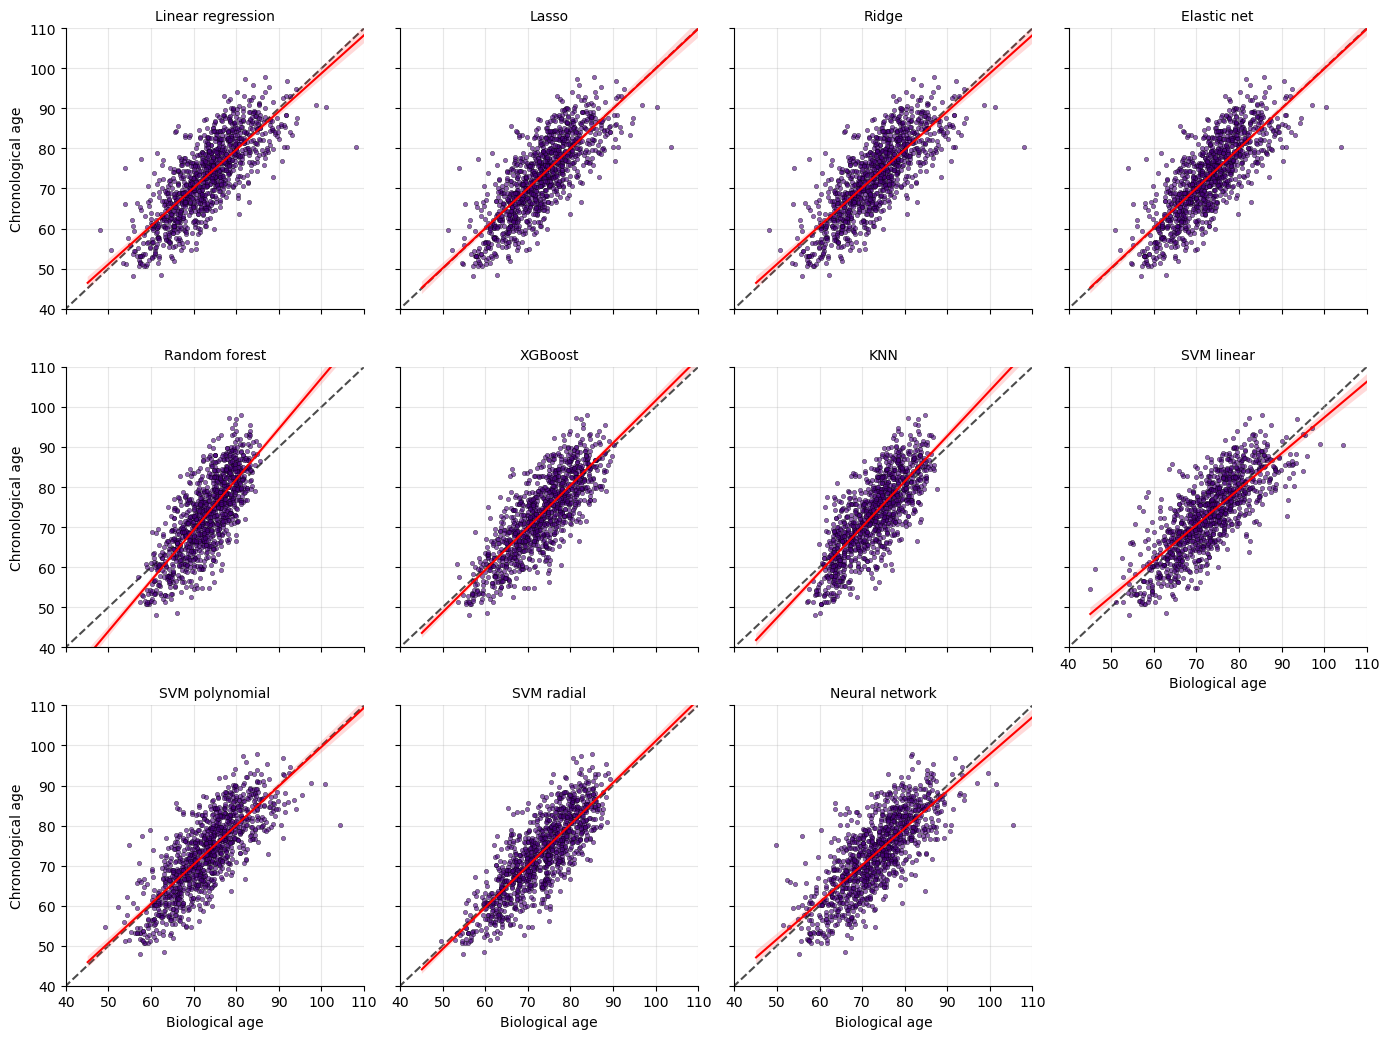

<Figure size 640x480 with 0 Axes>

In [180]:
def scatter_regression_line(data, color, **kwargs):
    sns.scatterplot(data=data, x="Predicted age", y="Age", s=10, color=color, alpha=0.6, edgecolor="black", linewidth=0.4, zorder=2, **kwargs)
    sns.regplot(data=data, x="Predicted age", y="Age", 
                scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Create the FacetGrid
g = sns.FacetGrid(df_all, col="Model", col_wrap=4, sharex=True, sharey=True, height=3.5, aspect=1)

# scattter plot for each facet
g.map_dataframe(scatter_regression_line, color='indigo')

# Add diagonal reference line and grid to each subplot
for ax in g.axes.flat:
    ax.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)  # Diagonal y = x
    ax.grid(True, alpha=0.3)            # Add grid lines

# Set labels and titles
g.set_axis_labels("Biological age", "Chronological age")
g.set_titles("{col_name}")
g.set(xlim=(40, 110), ylim=(40, 110))

# Adjust layout
g.fig.tight_layout(w_pad=1)

# Show plot
plt.show()
plt.savefig("Biological vs chronological age (all models).svg", format='svg', dpi=1200)

Scatter plot of test and train predicted vs chronological age for all models:

In [181]:
# Add a column indicating dataset type
train_preds["Set"] = "Train"
df_all["Set"] = "Test"

In [182]:
df_subset = train_preds.groupby("Model", group_keys=False).head(1070)
df_subset.iloc[1069:1071, :]

,Model,Age,Predicted age,Set
1069,Linear regression,85.228085,73.576644,Train
9630,Lasso,89.901370,78.896877,Train


In [183]:
# Combine them
combined_df = pd.concat([df_subset, df_all], ignore_index=True)
combined_df

,Model,Age,Predicted age,Set
0,Linear regression,89.901370,79.454449,Train
1,Linear regression,94.000000,88.391238,Train
2,Linear regression,97.879450,87.991865,Train
3,Linear regression,66.530134,64.572007,Train
4,Linear regression,73.568486,71.052979,Train
...,...,...,...,...
23535,Neural network,57.149897,65.232079,Test
23536,Neural network,51.250000,57.587377,Test
23537,Neural network,51.199540,59.304156,Test
23538,Neural network,51.355249,61.780677,Test


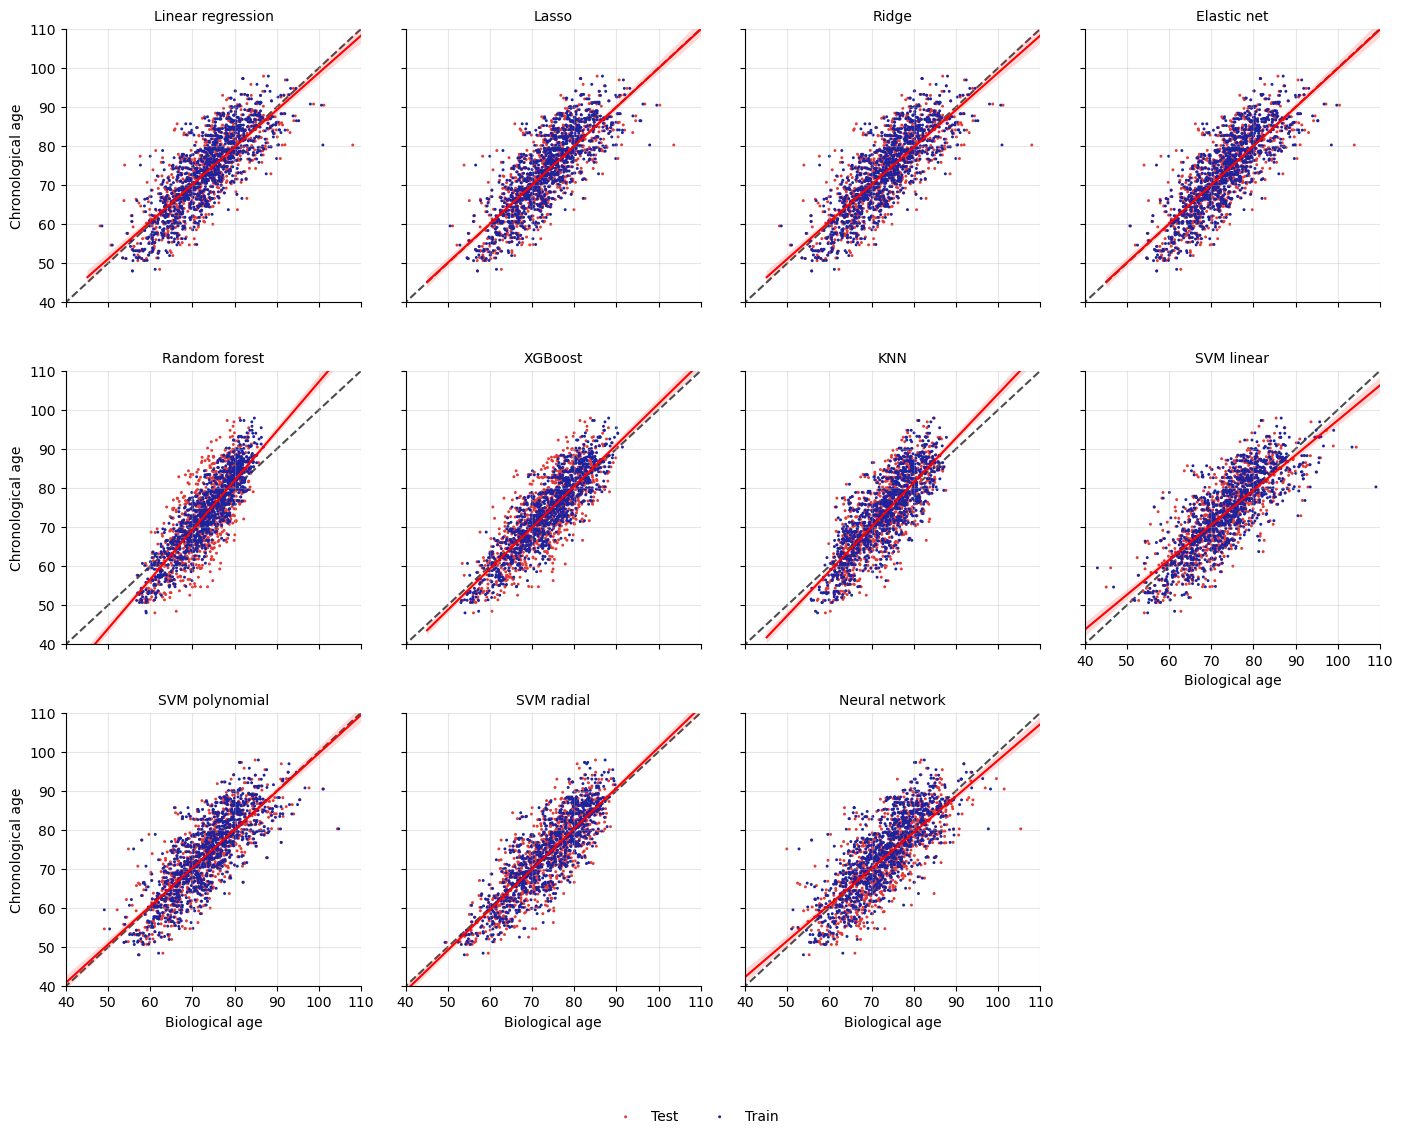

In [184]:
# Function to plot train and test points on same facet
def scatter_with_train_test(data, **kwargs):
    sns.scatterplot(
        data=data[data["Set"] == "Test"], 
        x="Predicted age", y="Age", edgecolor="none",
        s=18, color="#E53935", label="Test",
        marker="."
    )
    sns.scatterplot(
        data=data[data["Set"] == "Train"], 
        x="Predicted age", y="Age", edgecolor="none",
        s=18, color="#1b239f", label="Train",
        marker="."
    ) # #1b239f
    sns.regplot(
        data=data[data["Set"] == "Test"], 
        x="Predicted age", y="Age", 
        scatter=False, truncate=False, color="red", 
        line_kws={"linewidth": 1.5}
    )

# FacetGrid by model
g = sns.FacetGrid(combined_df, col="Model", col_wrap=4, sharex=True, sharey=True, height=3.5, aspect=1)

# Map scatter plots
g.map_dataframe(scatter_with_train_test)

# Add diagonal y = x reference lines
for ax in g.axes.flat:
    ax.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)
    ax.grid(True, alpha=0.3)

# Labels and titles
g.set_axis_labels("Biological age", "Chronological age")
g.set_titles("{col_name}")
g.set(xlim=(40, 110), ylim=(40, 110))

plt.subplots_adjust(wspace=0.15, hspace=0.25)

handles, labels = g.axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
g.fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.05),
    ncol=2, frameon=False
)

#plt.show()
plt.savefig('Biological vs chronological age (all models - train and test).png', format = 'png', dpi=1200, bbox_inches="tight")

Scatter plot of test predicted vs chronological age for SVM radial model:

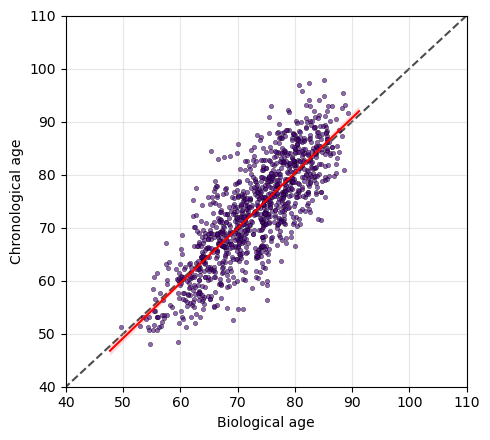

<Figure size 640x480 with 0 Axes>

In [185]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=df_all[df_all['Model'] == "SVM radial"], x="Predicted age", y="Age", 
                s=10, color='indigo', alpha=0.6, edgecolor="black", linewidth=0.4, zorder=2)
sns.regplot(data=df_all[df_all['Model'] == "SVM radial"], x="Predicted age", y="Age", 
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("Biological vs chronological age (SVM radial).svg", format='svg', dpi=1200)

Scatter plot of test predicted vs chronological age for elastic net model:

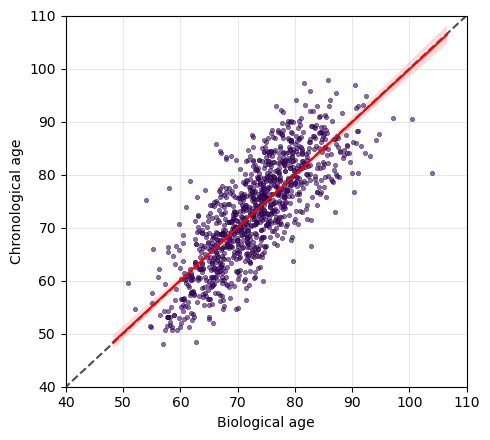

In [186]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=df_all[df_all['Model'] == "Elastic net"], x="Predicted age", y="Age", 
                s=10, color='indigo', alpha=0.6, edgecolor="black", linewidth=0.4, zorder=2)
sns.regplot(data=df_all[df_all['Model'] == "Elastic net"], x="Predicted age", y="Age", 
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.show()
plt.savefig("Biological vs chronological age (Elastic net).svg", format='svg', dpi=1200)

Scatter plot of test predicted vs chronological age for XGBoost model:

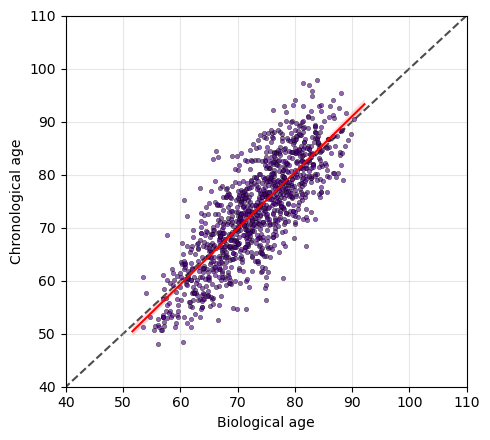

In [187]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=df_all[df_all['Model'] == "XGBoost"], x="Predicted age", y="Age", 
                s=10, color='indigo', alpha=0.6, edgecolor="black", linewidth=0.4, zorder=2)
sns.regplot(data=df_all[df_all['Model'] == "XGBoost"], x="Predicted age", y="Age", 
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.show()
plt.savefig("Biological vs chronological age (XGBoost).svg", format='svg', dpi=1200)

Scatter plot of train and test predicted vs chronological age for SVM radial model:

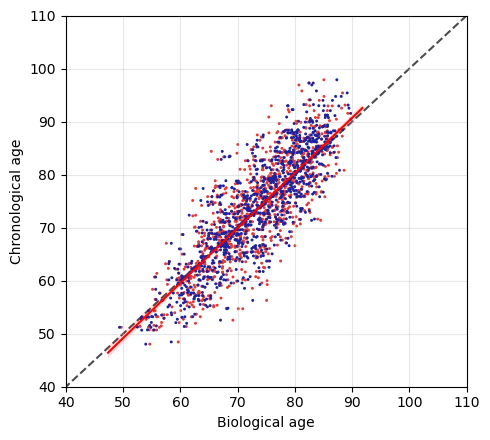

In [188]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=combined_df[(combined_df['Model'] == "SVM radial") & 
                (combined_df['Set'] == "Test")], 
                x="Predicted age", y="Age", 
                s=18, color="#E53935", zorder=1, 
                edgecolor='none', marker=".")
sns.scatterplot(data=combined_df[(combined_df['Model'] == "SVM radial") & 
                (combined_df['Set'] == "Train")], 
                x="Predicted age", y="Age", 
                s=18, color="#1b239f", zorder=2, 
                edgecolor='none', marker=".")
sns.regplot(data=combined_df[(combined_df['Model'] == "SVM radial") & 
                (combined_df['Set'] == "Test")], 
            x="Predicted age", y="Age",  
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
#plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.show()
plt.savefig("Biological vs chronological age (SVM radial - train and test).svg", format='svg', dpi=1200)

Scatter plot of train and test predicted vs chronological age for XGBoost model:

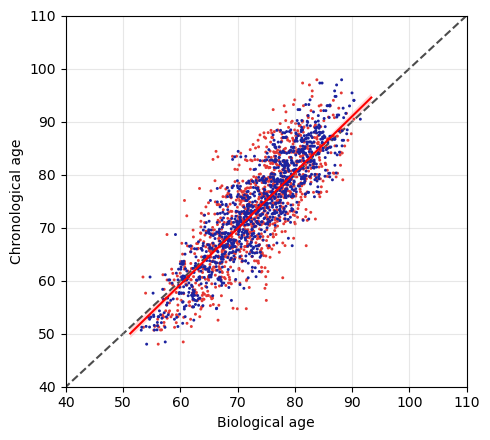

In [189]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=combined_df[(combined_df['Model'] == "XGBoost") & 
                (combined_df['Set'] == "Test")], 
                x="Predicted age", y="Age", 
                s=18, color="#E53935", zorder=1, 
                edgecolor='none', marker=".")
sns.scatterplot(data=combined_df[(combined_df['Model'] == "XGBoost") & 
                (combined_df['Set'] == "Train")], 
                x="Predicted age", y="Age", 
                s=18, color="#1b239f", zorder=2, 
                edgecolor='none', marker=".")
sns.regplot(data=combined_df[(combined_df['Model'] == "XGBoost") & 
                (combined_df['Set'] == "Test")], 
            x="Predicted age", y="Age",  
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
#plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.show()
plt.savefig("Biological vs chronological age (XGBoost - train and test).svg", format='svg', dpi=1200)

Scatter plot of train and test predicted vs chronological age for elastic net model:

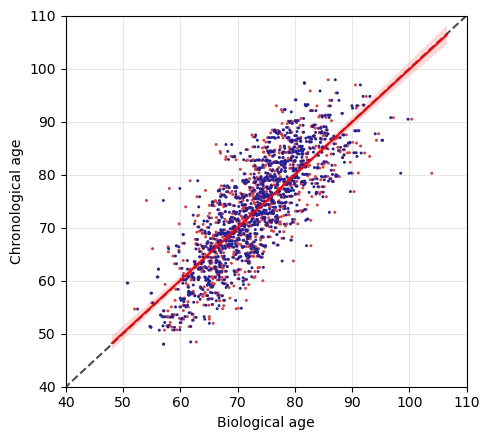

In [190]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=combined_df[(combined_df['Model'] == "Elastic net") & 
                (combined_df['Set'] == "Test")], 
                x="Predicted age", y="Age", 
                s=18, color="#E53935", zorder=1, 
                edgecolor='none', marker=".")
sns.scatterplot(data=combined_df[(combined_df['Model'] == "Elastic net") & 
                (combined_df['Set'] == "Train")], 
                x="Predicted age", y="Age", 
                s=18, color="#1b239f", zorder=2, 
                edgecolor='none', marker=".")
sns.regplot(data=combined_df[(combined_df['Model'] == "Elastic net") & 
                (combined_df['Set'] == "Test")], 
            x="Predicted age", y="Age",  
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
#plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.show()
plt.savefig("Biological vs chronological age (elastic net - train and test).svg", format='svg', dpi=1200)

Scatter plot of train predicted vs chronological age for all models:

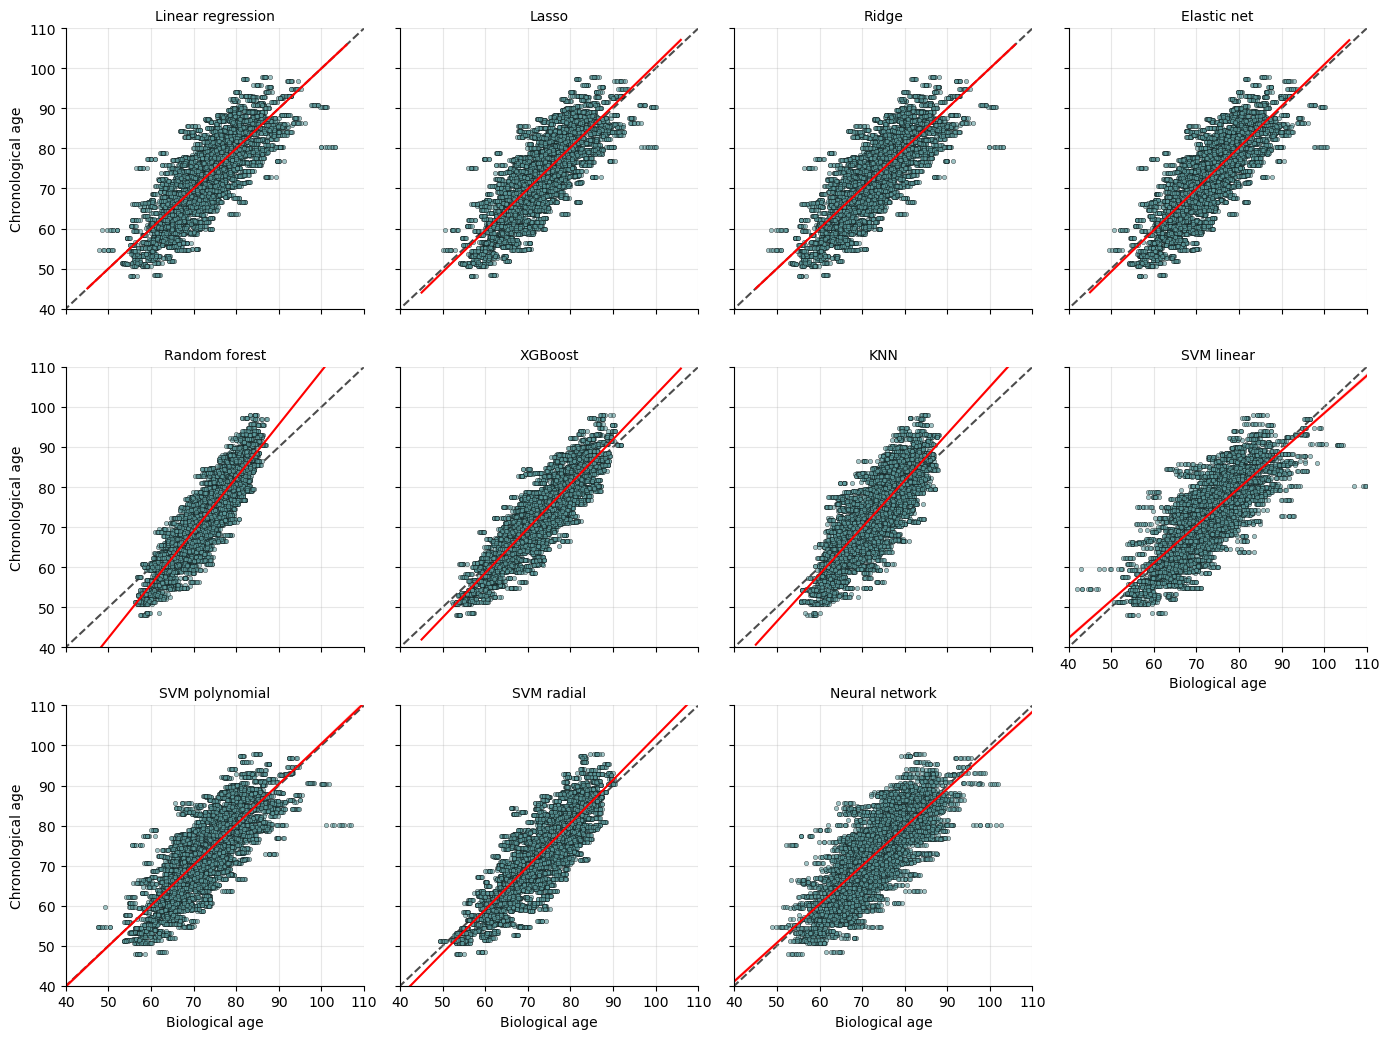

In [191]:
# Create the FacetGrid
g = sns.FacetGrid(train_preds, col="Model", col_wrap=4, sharex=True, sharey=True, height=3.5, aspect=1)

# KDE plot for each facet
g.map_dataframe(scatter_regression_line, color='cadetblue')

# Add diagonal reference line and grid to each subplot
for ax in g.axes.flat:
    ax.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)  # Diagonal y = x
    ax.grid(True, alpha=0.3)            # Add grid lines

# Set labels and titles
g.set_axis_labels("Biological age", "Chronological age")
g.set_titles("{col_name}")
g.set(xlim=(40, 110), ylim=(40, 110))

# Adjust layout
g.fig.tight_layout(w_pad=1)

# Show plot
plt.savefig("Biological vs chronological age (all models - training).svg", format='svg', dpi=1200)
#plt.show()

Scatter plot of train predicted vs chronological age for SVM radial model:

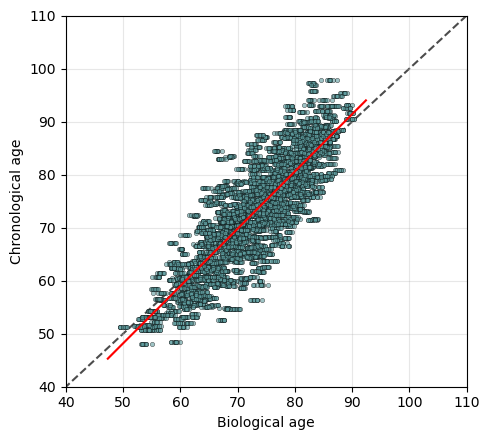

In [192]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=train_preds[train_preds['Model'] == "SVM radial"], x="Predicted age", y="Age", 
                s=10, color='cadetblue', alpha=0.6, edgecolor="black", linewidth=0.4, zorder=2)
sns.regplot(data=train_preds[train_preds['Model'] == "SVM radial"], x="Predicted age", y="Age", 
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.show()
plt.savefig("Biological vs chronological age (SVM radial - train).svg", format='svg', dpi=1200)

Scatter plot of train predicted vs chronological age for elastic net model:

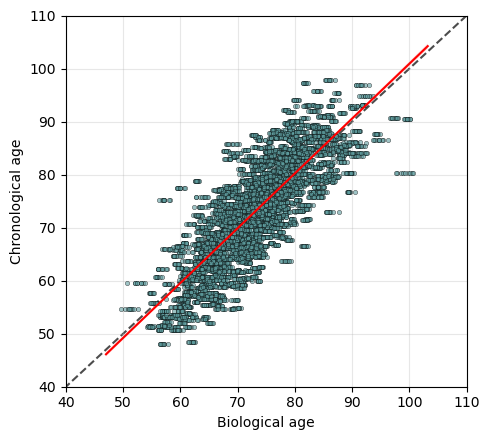

In [193]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=train_preds[train_preds['Model'] == "Elastic net"], x="Predicted age", y="Age", 
                s=10, color='cadetblue', alpha=0.6, edgecolor="black", linewidth=0.4, zorder=2)
sns.regplot(data=train_preds[train_preds['Model'] == "Elastic net"], x="Predicted age", y="Age", 
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.show()
plt.savefig("Biological vs chronological age (Elastic net - train).svg", format='svg', dpi=1200)

Scatter plot of train predicted vs chronological age for XGBoost model:

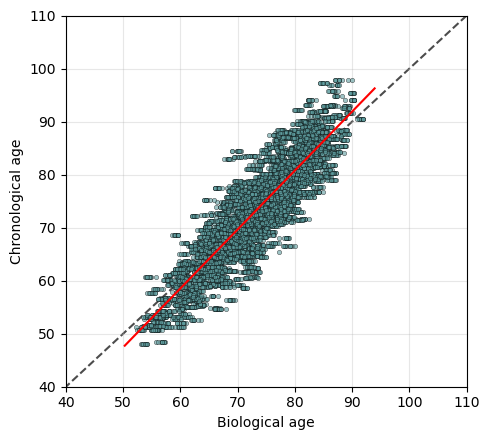

In [194]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(data=train_preds[train_preds['Model'] == "XGBoost"], x="Predicted age", y="Age", 
                s=10, color='cadetblue', alpha=0.6, edgecolor="black", linewidth=0.4, zorder=2)
sns.regplot(data=train_preds[train_preds['Model'] == "XGBoost"], x="Predicted age", y="Age", 
            scatter=False, truncate=False, color="red", line_kws={"linewidth": 1.5})

# Add y = x reference line
plt.plot([20, 120], [20, 120], 'k--', alpha=0.7, zorder=0)

plt.xlabel("Biological age")
plt.ylabel("Chronological age")
plt.xlim(40, 110)
plt.ylim(40, 110)
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.show()
plt.savefig("Biological vs chronological age (XGBoost - train).svg", format='svg', dpi=1200)

To compare the predictive performance of the different models in both the train and test sets I will produce plots of each metric. To do this, I will define a function plot_model_metric 

In [206]:
per_fold_df = pd.DataFrame(per_fold_metrics)

def plot_metric(metric_col, ylabel, filename, 
                metrics_df, 
                per_fold_df,
                colour,
                label_offset,
                ylim):
    """
    Plot per-model metric values with per-fold scatter, mean markers, and highlight the best model.
    
    metric_col defines which metric to plot and whether it is the train or test values.
    ylabel is the corresponding label for the y-axis.
    filename is the output filename for saving the SVG.
    metrics_df is the dataframe containing the metrics per model.
    per_fold_df is the dataframe containing the per-fold metrics
    label_offset is the vertical offset for the mean value labels (as a fraction of the value, default = -0.02).
    ylim is the limits for the y-axis.
    """
    model_labels = per_fold_df['Model'].unique()
    xticks = np.arange(len(model_labels))

    fig, ax = plt.subplots(figsize=(12, 6))

    # Highlight best model (lowest metric value)
    min_index = np.argmin(metrics_df["Test RMSE"])
    ax.axvspan(min_index - 0.5, min_index + 0.5, color='thistle', alpha=0.3, zorder=0)

    # Plot mean metric per model
    for i, val in enumerate(metrics_df[metric_col]):
        ax.scatter(i, val, color=colour, zorder=3, label='Mean' if i == 0 else "")
        ax.text(i, val + label_offset * val, f"{val:.2f}", 
                ha='center', va='bottom', fontsize=9, color=colour,
                bbox=dict(boxstyle="round,pad=0.2", edgecolor=colour, facecolor='white'))

    # Plot per-fold metrics (jittered points)
    for i, model in enumerate(model_labels):
        fold_vals = per_fold_df.loc[per_fold_df["Model"] == model, metric_col]
        ax.scatter(np.full_like(fold_vals, i, dtype=float) +
                   np.random.uniform(-0.2, 0.2, len(fold_vals)),
                   fold_vals, color=colour, alpha=0.15, s=60, zorder=2, label='CV' if i == 0 else "")

    # X-axis formatting
    ax.set_xticks(xticks)
    ax.set_xticklabels(model_labels, rotation=45, ha='right')

    # Labels and grid
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.grid(alpha=0.3)

    # Vertical separator lines
    for x in xticks[:-1] + 0.5:
        ax.axvline(x=x, color='gray', linestyle='dotted', zorder=0)

    # Clean legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),
              loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)

    plt.subplots_adjust(bottom=0.25, top=0.9)
    plt.savefig(filename, format='svg', dpi=1200)

Test RMSE plots with average and jittered scatter:

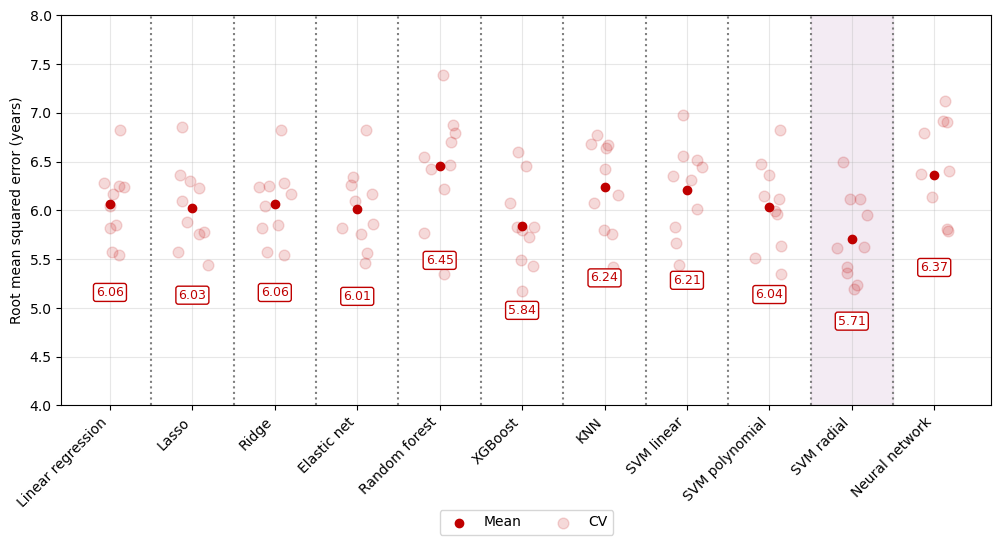

In [207]:
plot_metric(metric_col="Test RMSE",
            ylabel="Root mean squared error (years)",
            filename="RMSE.svg",
            metrics_df=metrics_df,
            per_fold_df=per_fold_df,
            colour = '#bf0000',
            label_offset=-0.16,
            ylim=(4, 8))

Train RMSE plots with mean and jittered scatter:

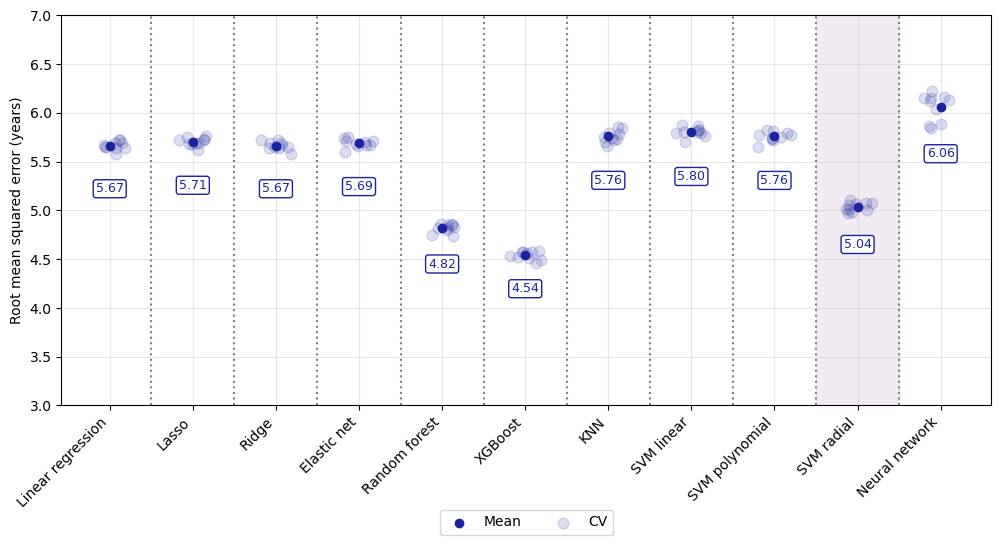

In [208]:
plot_metric(metric_col="Train RMSE",
            ylabel="Root mean squared error (years)",
            filename="RMSE train.svg",
            metrics_df=metrics_df,
            per_fold_df=per_fold_df,
            colour = '#1b239f',
            label_offset=-0.09,
            ylim=(3, 7))

Test MAE plots with mean and jittered scatter:

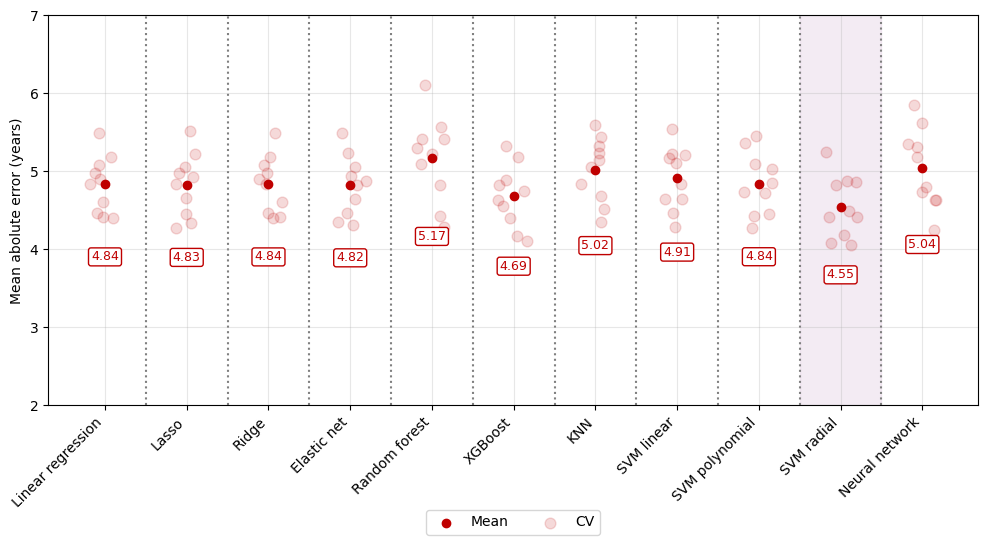

In [198]:
plot_metric(metric_col="Test MAE",
            ylabel="Mean abolute error (years)",
            filename="MAE.svg",
            metrics_df=metrics_df,
            per_fold_df=per_fold_df,
            colour = '#bf0000',
            label_offset=-0.21,
            ylim=(2, 7))

Train MAE plots with mean and jittered scatter:

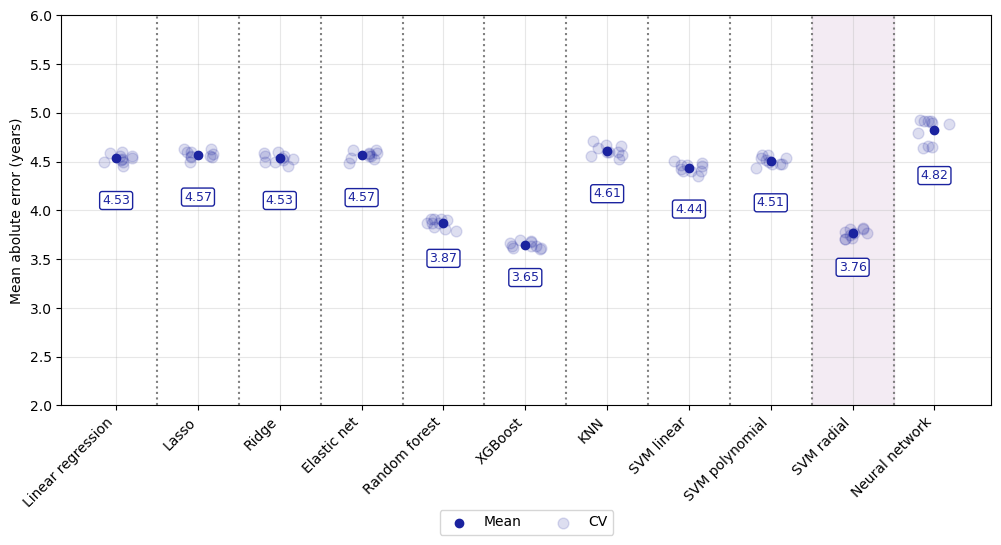

In [199]:
plot_metric(metric_col="Train MAE",
            ylabel="Mean abolute error (years)",
            filename="MAE train.svg",
            metrics_df=metrics_df,
            per_fold_df=per_fold_df,
            colour = '#1b239f',
            label_offset=-0.11,
            ylim=(2, 6))

Test $R^2$ plots with mean and jittered scatter:

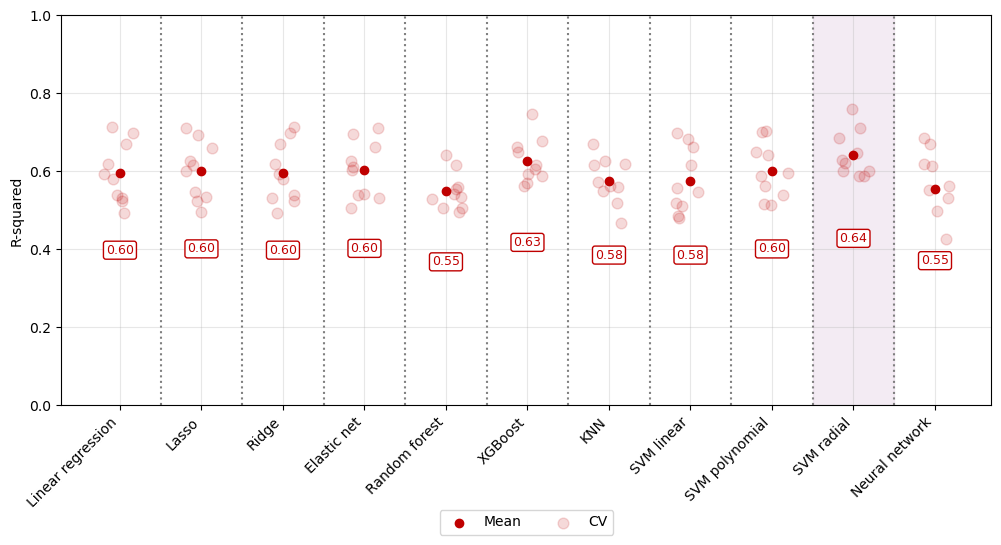

In [200]:
plot_metric(metric_col="Test R2",
            ylabel="R-squared",
            filename="R-squared.svg",
            metrics_df=metrics_df,
            per_fold_df=per_fold_df,
            colour = '#bf0000',
            label_offset=-0.36,
            ylim=(0, 1))

Train $R^2$ plots with mean and jittered scatter:

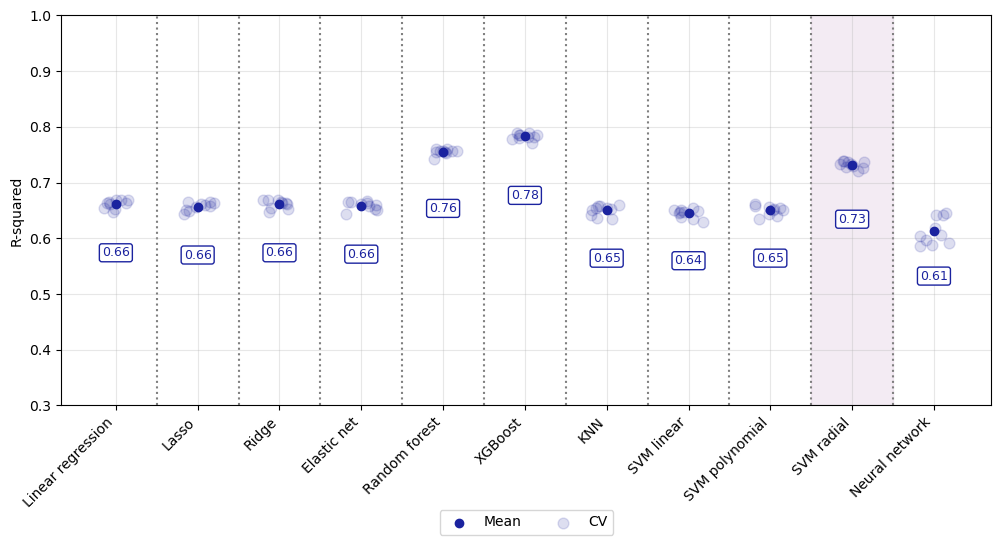

In [201]:
plot_metric(metric_col="Train R2",
            ylabel="R-squared",
            filename="R-squared train.svg",
            metrics_df=metrics_df,
            per_fold_df=per_fold_df,
            colour = '#1b239f',
            label_offset=-0.15,
            ylim=(0.3, 1))

Test r plots with mean and jittered scatter:

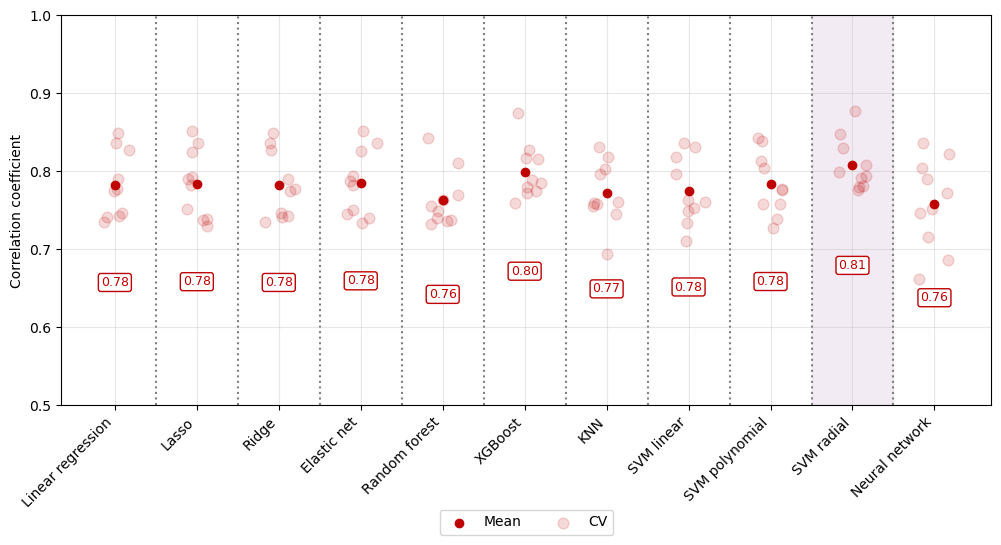

In [213]:
plot_metric(metric_col="Test r",
            ylabel="Correlation coefficient",
            filename="Correlation coefficient.svg",
            metrics_df=metrics_df,
            per_fold_df=per_fold_df,
            colour = '#bf0000',
            label_offset=-0.17,
            ylim=(0.5, 1))

Train $R^2$ plots with mean and jittered scatter:

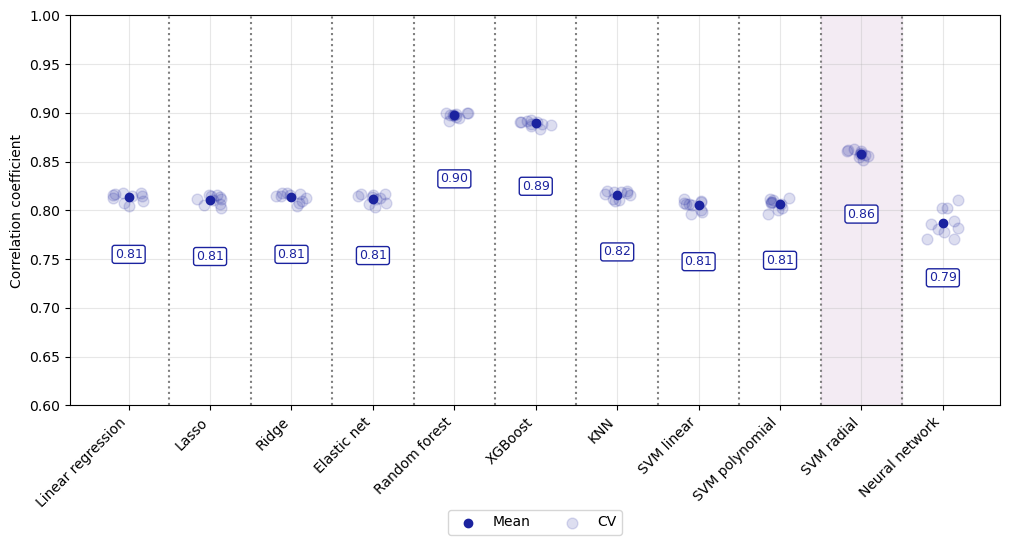

In [219]:
plot_metric(metric_col="Train r",
            ylabel="Correlation coefficient",
            filename="Correlation coefficient train.svg",
            metrics_df=metrics_df,
            per_fold_df=per_fold_df,
            colour = '#1b239f',
            label_offset=-0.08,
            ylim=(0.6, 1))

In [220]:
metrics_df['RMSE % Diff'] = abs(metrics_df['Train RMSE'] - metrics_df['Test RMSE']) / ((metrics_df['Train RMSE'] + metrics_df['Test RMSE']) / 2) * 100
metrics_df['MAE % Diff'] = abs(metrics_df['Train MAE'] - metrics_df['Test MAE']) / ((metrics_df['Train MAE'] + metrics_df['Test MAE']) / 2) * 100
metrics_df['r % Diff'] = abs(metrics_df['Train r'] - metrics_df['Test r']) / ((metrics_df['Train r'] + metrics_df['Test r']) / 2) * 100
metrics_df['R2 % Diff'] = abs(metrics_df['Train R2'] - metrics_df['Test R2']) / ((metrics_df['Train R2'] + metrics_df['Test R2']) / 2) * 100

In [221]:
metrics_df = metrics_df.iloc[:, [0, 1, 2, 9, 3, 4, 10, 5, 6, 11, 7, 8, 12]]
metrics_df = metrics_df.sort_values(by='Test RMSE', ascending=True)

metrics_df.round(decimals=2)

,Model,Train RMSE,Test RMSE,RMSE % Diff,Train MAE,Test MAE,MAE % Diff,Train r,Test r,r % Diff,Train R2,Test R2,R2 % Diff
9,SVM radial,5.04,5.71,12.54,3.76,4.55,18.81,0.86,0.81,5.95,0.73,0.64,12.95
5,XGBoost,4.54,5.84,25.13,3.65,4.69,24.95,0.89,0.80,10.60,0.78,0.63,22.06
3,Elastic net,5.69,6.01,5.54,4.57,4.82,5.42,0.81,0.78,3.40,0.66,0.60,8.79
1,Lasso,5.71,6.03,5.52,4.57,4.83,5.42,0.81,0.78,3.44,0.66,0.60,8.84
8,SVM polynomial,5.76,6.04,4.70,4.51,4.84,7.11,0.81,0.78,2.88,0.65,0.60,7.87
2,Ridge,5.67,6.06,6.75,4.53,4.84,6.46,0.81,0.78,3.89,0.66,0.60,10.42
0,Linear regression,5.67,6.06,6.77,4.53,4.84,6.47,0.81,0.78,3.89,0.66,0.60,10.44
7,SVM linear,5.80,6.21,6.76,4.44,4.91,10.25,0.81,0.78,3.77,0.64,0.58,11.23
6,KNN,5.76,6.24,7.99,4.61,5.02,8.47,0.82,0.77,5.50,0.65,0.58,12.03
10,Neural network,6.06,6.37,4.94,4.82,5.04,4.40,0.79,0.76,3.69,0.61,0.55,10.01


Next, I will re-run the SVM polynomial model so I can collect the permutation_importance and determine which CpG sites contributed the most to predictive accuracy

In [222]:
from sklearn.inspection import permutation_importance

test_ids = []
importances_list = []

# Store metrics
train_r2_scores, test_r2_scores = [], []
train_mse_scores, test_mse_scores = [], []

# Store predictions and actual values
y_preds_train, y_actual_train = [], []
y_preds_test, y_actual_test = [], []

for fold_idx, (train_idx, test_idx) in enumerate(splits):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    ids_test = significant.iloc[test_idx]['ID'].values

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) 
    
    rbf_svr.fit(X_train, y_train)
    y_pred_train = rbf_svr.predict(X_train)
    y_pred_test = rbf_svr.predict(X_test)

    # Save predictions for plotting
    y_preds_train.extend(y_pred_train)
    y_actual_train.extend(y_train)
    y_preds_test.extend(y_pred_test)
    y_actual_test.extend(y_test)
    test_ids.extend(ids_test)


    # Compute r2 and MSE metrics to evaluate regression models 
    train_r2_scores.append(r2_score(y_train, y_pred_train))
    test_r2_scores.append(r2_score(y_test, y_pred_test))
    train_mse_scores.append(mean_squared_error(y_train, y_pred_train))
    test_mse_scores.append(mean_squared_error(y_test, y_pred_test))

    result = permutation_importance(
        rbf_svr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )

    importances_list.append(result.importances_mean)

# Average over 10 folds
mean_importances = np.mean(importances_list, axis=0)

# Build DataFrame
df_importance = pd.DataFrame({
    "CpG": significant.axes[1][2:].tolist(),
    "Importance": mean_importances
})

# Sort and take top 20
df_top20 = df_importance.sort_values(by="Importance", ascending=False).head(20)

y_preds_train = np.array(y_preds_train)
y_actual_train = np.array(y_actual_train)
y_preds_test = np.array(y_preds_test)
y_actual_test = np.array(y_actual_test)
test_ids = np.array(test_ids)

print("Average train R2:", np.mean(train_r2_scores))
print("Average test R2:", np.mean(test_r2_scores))
print("Average train MSE:", np.mean(train_mse_scores))
print("Average test MSE:", np.mean(test_mse_scores))

Average train R2: 0.732448131054532
Average test R2: 0.6433543223785754
Average train MSE: 25.38047684985449
Average test MSE: 32.79859262266822


Permutation importance, i.e. which CpG sites are most important based on their impact on the trained model's prediction

In [47]:
df_top20

,CpG,Importance
16,cg06639320,0.034682
0,cg16867657,0.033897
12,cg23500537,0.033043
1,cg22454769,0.031927
32,cg09809672,0.021380
37,cg10501210,0.017861
7,cg07927379,0.017463
8,cg12554573,0.017146
18,cg00755588,0.015048
28,cg07553761,0.014947


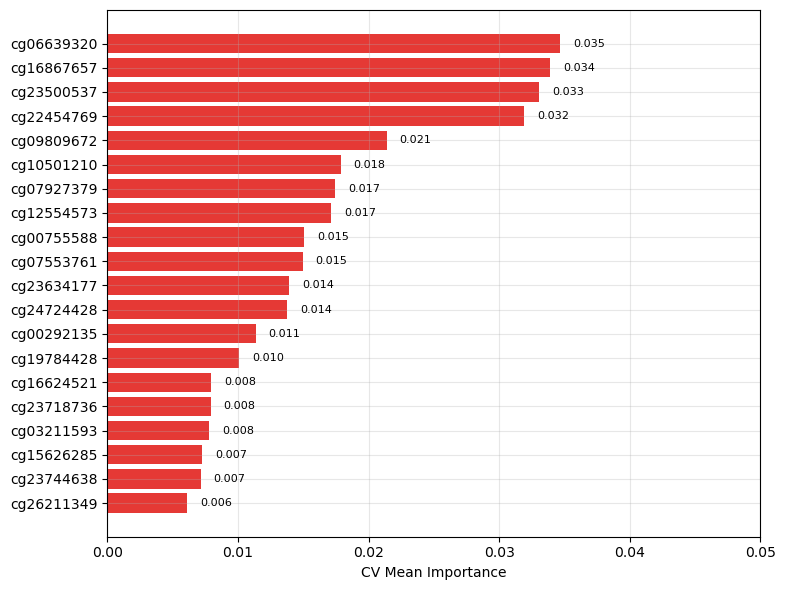

In [48]:
plt.figure(figsize=(8, 6))
plt.barh(df_top20["CpG"][::-1], df_top20["Importance"][::-1], color='#E53935')
for i, v in enumerate(df_top20["Importance"][::-1]):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center', fontsize=8)

plt.xlabel("CV Mean Importance")
plt.tight_layout()
plt.grid(alpha=0.3)
plt.xlim(0, 0.05)
#plt.show()
plt.savefig("Variable importance.svg", format='svg', dpi=1200)

Most clocks calculate age acceleration as the residuals from regressing biological age onto chronological age. While this gives an indication of whether someone is biologically older or younger than their chronological age, I don't think that this indicates whether someone has accelerated ageing. Therefore, I will also calculate the biological ageing rate which corresponds to the rate of hcange in biological age across the samples. 

In [223]:
predictions_actual = pd.DataFrame({
    "ID": test_ids,
    "chronological_age": y_actual_test,
    "biological_age": y_preds_test
})
predictions_actual.head(10)

,ID,chronological_age,biological_age
0,5,84.531143,85.633451
1,10,74.347030,74.380469
2,13,72.777394,74.521013
3,28,90.062300,80.183886
4,30,90.582330,82.016925
5,37,80.224195,75.760913
6,45,87.946800,83.862171
7,50,80.053200,81.922592
8,55,88.900753,81.868989
9,55,96.906229,80.698085


In [224]:
import statsmodels.api as sm

biological_ageing_rate = []

for subject, group in predictions_actual.groupby("ID"):
    X = sm.add_constant(group["chronological_age"])
    y = group["biological_age"]
    model = sm.OLS(y, X).fit()
    
    slope = model.params["chronological_age"]  # biological ageing rate
    
    # Baseline biological age (earliest chronological age for this subject)
    baseline_bio_age = group.loc[group["chronological_age"].idxmin(), "biological_age"]
    
    biological_ageing_rate.append({
        "ID": subject,
        "ageing_rate": slope,
        "baseline_bio_age": baseline_bio_age
    })

biological_ageing_rate = pd.DataFrame(biological_ageing_rate)
biological_ageing_rate.head(50)

,ID,ageing_rate,baseline_bio_age
0,1,0.913571,82.131308
1,2,0.896358,84.257682
2,3,0.868985,85.055729
3,4,0.987987,62.444563
4,5,0.653653,74.077560
5,6,0.987726,66.786312
6,7,0.955315,64.024442
7,8,0.734151,65.335729
8,9,0.704467,64.387783
9,10,1.079451,66.959866
